The following are simplifications for the purpose of comparing neutron star conversion rates

- Neutron star and black hole sizes aren't to scale with respect to distance between stars
- All stars start out at the same age in the simulation
- Black hole sizes is visuaized by their Schwarzschild radii

Usage Notes

- When saving as a gif JupyterLab or Notebook on the UC Berkeley Data Hub, the kernel may crash with a high number of frames. Uploaded examples were run locally where the memory limits are much higher.


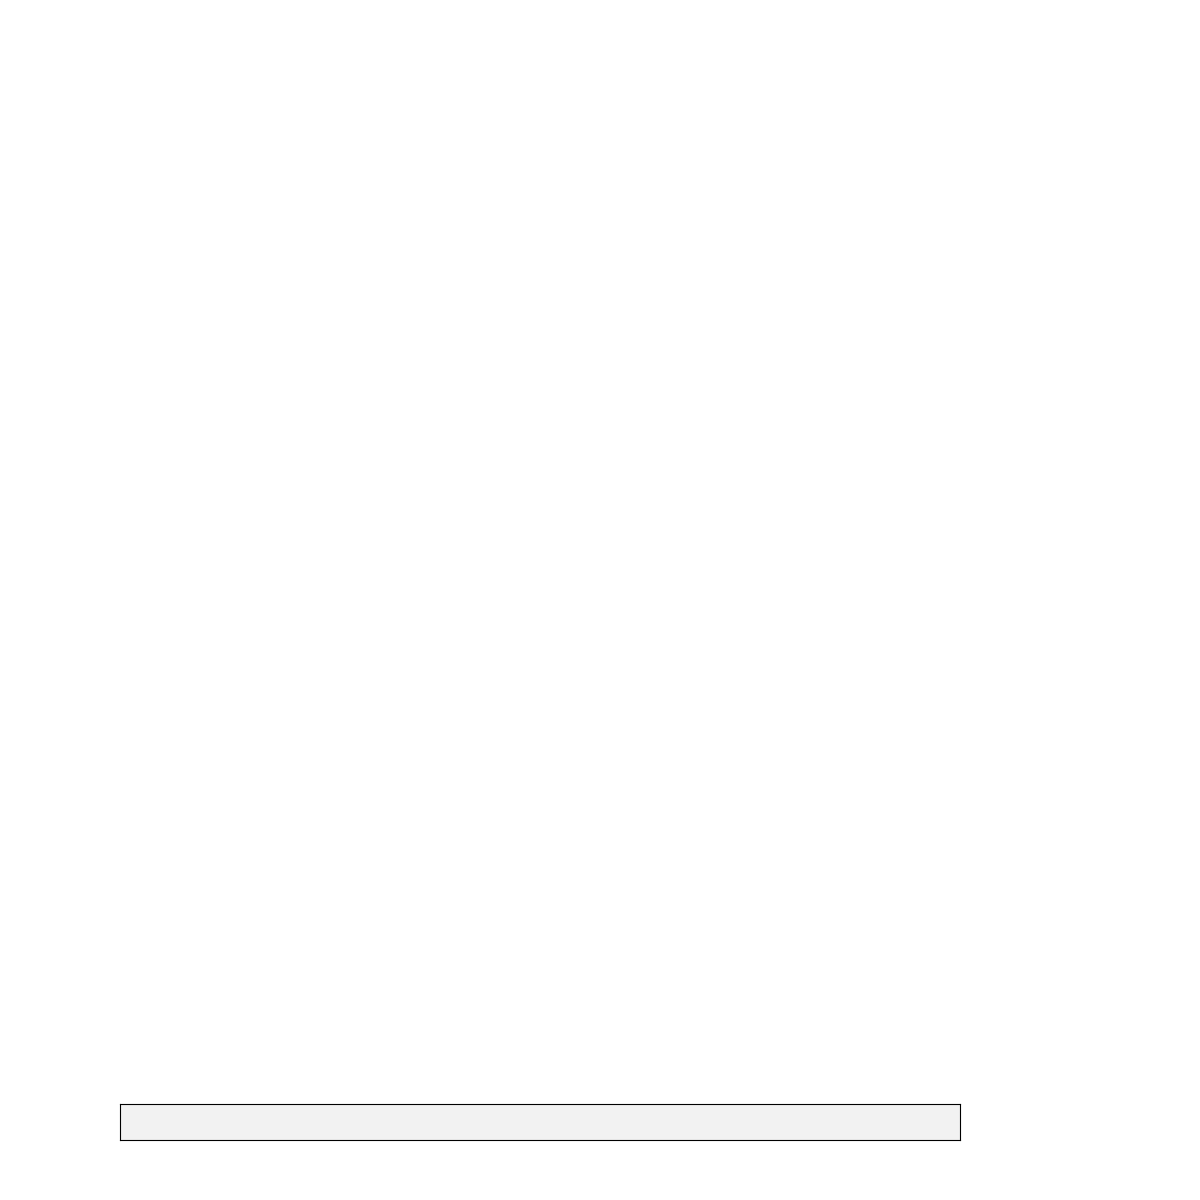

In [1]:
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import distance
import numpy as np
from ipywidgets import IntProgress, FloatSlider, FloatLogSlider, IntSlider, VBox, HBox, Output, Layout
from ipywidgets import FloatSlider, IntText, RadioButtons, Text, Label

import ipywidgets as widgets
from IPython.display import display
from enum import Enum

from matplotlib import animation
from matplotlib.animation import PillowWriter
from matplotlib.widgets import Button, Slider, TextBox

%matplotlib ipympl

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.set_visible(False)

# Make a horizontal slider to control the frequency.

axtime = fig.add_axes([0.20, 0.1, 0.50, 0.03])
time_slider = Slider(
    ax=axtime,
    label='Elapsed Time',
    valmin=0,
    valmax=1000,
    valinit=0,
    dragging=False
)
time_slider._handle.set_visible(False)
axtime.set_visible(False)

ax_labels = fig.add_axes([0.10, 0.05, 0.70, 0.03])
text_box = TextBox(ax_labels, "", textalignment="left")

# Create the "Start" and "Stop" buttons
start_button = widgets.Button(description='Start')
stop_button = widgets.Button(description='Stop', layout=Layout(display='none'))  # Initially hidden

# Create layout for alignment
container_layout = Layout(justify_content='flex-start')
button_box = HBox([start_button, stop_button], layout=container_layout)

# Create input widgets for numeric values and sliders
num_stars = IntText(value=200, min=50, max=500, description='Num Stars', disabled=False, layout=Layout(width='75%'))
m_x_slider = FloatSlider(value=623844.20, min=1, max=9.4e5, step=0.1, description='m_x (GeV)', disabled=False)
cs_XB_slider = FloatLogSlider(value=1e-45, min=-47, max=-45, step=0.01, description='cs_XB', disabled=False)

# Time increment per frame
time_scale_slider = IntSlider(value=1e9, min=1e7, max=1e10, step=1e7, description="Years/Frame")
#time_scale_label = Label(value='Animate or Save')
#time_scale_box = HBox([time_scale_slider, stop_button], layout=container_layout)


# Create radio buttons for "Loop Animation" and "Save Animation"
loop_save_options = RadioButtons(
    options=['Loop Animation', 'Save Animation'],
    description='',
    layout=Layout(width='200px')
)

# Text input for "Filename"
filename_input = Text(description='Filename', disabled=True)

# Group radio buttons and filename input in a VBox
loop_save_radio_group = VBox([
    Label(value='Animate or Save'),
    HBox([loop_save_options]),
    HBox([filename_input])
])

# Create radio buttons for simulation type
sim_type_options = RadioButtons(
    options=['Whole Milky Way', 'Milky Way Quadrant', 'Cubic Kiloparsec'],
    description='',
    layout=Layout(width='200px')
)

# Dark matter density goes down as a function of the distance from the galactic center
distance_from_gc_kpc = IntText(value=5, disabled=True, layout=Layout(width='60px'))
distance_label = Label(value='Dist From Galactic Center kpc')

gc_distance_vbox = VBox([distance_label, distance_from_gc_kpc])
gc_distance_vbox.layout.display = 'none'

# Group radio buttons and filename input in a VBox
sim_type_radio_group = VBox([
    Label(value='Simulation Space'),
    HBox([sim_type_options]),
    gc_distance_vbox
])

# Function to enable inputs
def enable_inputs():
    num_stars.disabled = False
    m_x_slider.disabled = False
    cs_XB_slider.disabled = False
    loop_save_options.disabled = False
    sim_type_options.disabled = False

    if list(loop_save_options.options).index(loop_save_options.value) == 1:
        filename_input.disabled = False
        
    if list(sim_type_options.options).index(sim_type_options.value) == 2:
        distance_from_gc_kpc.disabled = False

# Function to disable inputs
def disable_inputs():
    num_stars.disabled = True
    m_x_slider.disabled = True
    cs_XB_slider.disabled = True
    loop_save_options.disabled = True
    sim_type_options.disabled = True
    filename_input.disabled = True
    distance_from_gc_kpc.disabled = True

# Function to handle enabling/disabling the filename input based on radio selection
def toggle_filename_input(change):
    if list(loop_save_options.options).index(change['new']) == 1:
        filename_input.disabled = False
    else:
        filename_input.disabled = True

# Attach the change handler to the save options radio button group
loop_save_options.observe(toggle_filename_input, names='value')

# Function to handle enabling/disabling the filename input based on radio selection
def select_sim_type_input(change):
    if list(sim_type_options.options).index(change['new']) == 2:
        distance_from_gc_kpc.disabled = False
        gc_distance_vbox.layout.display = 'flex'
    else:
        distance_from_gc_kpc.disabled = True
        gc_distance_vbox.layout.display = 'none'

# Attach the change handler to the sim type radio button group
sim_type_options.observe(select_sim_type_input, names='value')

# Formulas

import numpy as np

def capture_rate(p_x, m_x, cs_XB, xi, n_tot, v_esc=1.8e+5, v_disp=220):
    """
    Capture rate of dark matter based on various parameters
    This formula was taken from:
    https://arxiv.org/pdf/1103.5472 pg:5
    

    Parameters:
    p_x: (float): Local dark matter density 
    m_x: : Mass of a single dark matter particle 
    v_esc: DM escape velocity at neutron star surface
    v_disp: DM velocity dispersion around neutron star
    cs_XB: 
    n_tot: Total number of neutrons in host star

    Returns:
    float: The timescale in seconds.
    """
    return np.sqrt(6/np.pi)*(p_x/m_x)*((v_esc**2)/(v_disp**2))*(v_disp*cs_XB)*xi*n_tot

def nfw_density(r, rho_s=0.47, r_s=14.5):
    """
    Function to compute the density at a given radius using NFW profile

    Parameters:
    r_s: (float): Scale radius in kpc 

    Returns:
    float: The timescale in seconds.
    """
    return rho_s / ((r / r_s) * (1 + r / r_s)**2)

def time_collapse(C, N_x_self):
    return (1 / C) * N_x_self

def n_x_self(m_x, T_core):
    return 2.1e36 * ((1e5 / m_x) ** 2.5) * ((T_core / (2.1e6)) ** 1.5)

def t_swallow(M_bh):
    """
    Calculate the time for a tiny black hole in the core of a neutron star
    to consume/swallow the neutron star
    This formula was taken from:
    https://arxiv.org/pdf/1103.5472 pg:5

    Parameters:
    M_bh: (float): Mass of black hole in GeV 

    Returns:
    float: Time in seconds
    """
    return 2.3e-5*(1.115e57/M_bh)

def schwarzschild_radius(M):
    """
    Calculate the Schwarzschild radius for a given mass in solar masses.

    Parameters:
    M (float): Mass of the object in solar masses.
    M_sun (float): Solar mass in kg (default is the solar mass).

    Returns:
    float: The Schwarzschild radius in km.
    """
    # Convert mass from solar masses to kilograms
    G = 6.67430e-11  # Gravitational constant in m^3 kg^-1 s^-2
    c = 2.99792458e8  # Speed of light in m/s
    M_sun = 1.98847e30
    mass_in_kg = M * M_sun
    return (2 * G * mass_in_kg / c**2) / 1000

def escape_velocity(mass_solar_masses, radius_km):
    # Gravitational constant in m^3 kg^-1 s^-2
    G = 6.67430e-11
    
    # Convert mass from solar masses to kilograms
    mass_kg = mass_solar_masses * 1.989e30
    
    # Convert radius from kilometers to meters
    radius_m = radius_km * 1000
    
    # Calculating escape velocity in m/s
    velocity_m_per_s = math.sqrt(2 * G * mass_kg / radius_m)
    
    # Converting m/s to km/s
    velocity_km_per_s = velocity_m_per_s / 1000
    
    return velocity_km_per_s

    
def generate_neutron_star_coordinates_in_sector(n_x, R_d=3.5, Z_d=0.3, angle_degrees=360):
    """
    Generate random (x, y, z) coordinates for neutron stars in the Milky Way within a specified angular sector.
    
    Parameters:
    - n_x (int): Number of neutron stars to generate.
    - R_d (float): Scale length of the galactic disk in kpc (default: 3.5 kpc).
    - Z_d (float): Scale height above/below the plane in kpc (default: 0.3 kpc).
    - angle_degrees (float): Angular sector (0 to 360 degrees) within which to generate stars.

    Returns:
    - numpy array: An array of shape (n_x, 3) containing the x, y, and z coordinates.
    """
    # Ensure angle_degrees is between 0 and 360
    angle_degrees = np.clip(angle_degrees, 0, 360)
    angle_radians = np.deg2rad(angle_degrees)

    # Generate radial distances using an exponential distribution
    U = np.random.uniform(size=n_x)
    R = -R_d * np.log(1 - U)

    # Generate angles uniformly within the specified angular sector
    theta = np.random.uniform(0, angle_radians, n_x)

    # Generate vertical heights using an exponential distribution
    U = np.random.uniform(size=n_x)
    Z = Z_d * np.log(1 / (1 - U)) * np.sign(np.random.uniform(-1, 1, n_x))

    # Convert polar coordinates (R, theta) to Cartesian coordinates (x, y)
    x = R * np.cos(theta)
    y = R * np.sin(theta)

    # Combine (x, y, z) into a final array
    coordinates = np.column_stack((x, y, Z))
    return coordinates

largest_collapse_time = 0
min_density = float('inf')
max_density = 0
class Location:
    def __init__(self, location):
        self.x = location[0]
        self.y = location[1]
        self.z = location[2]

        #self.x = np.random.randint(-100, 100)
        #self.y = np.random.randint(-100, 100)
        #self.z = np.random.randint(-100, 100)
        
class Star:
    """Base star class representing a star in different phases""" 
    class State(Enum):
        COLLAPSING = 1
        SWALLOWING = 2
        FINISHED = 3
        
    def __init__(self, location):
        global largest_collapse_time, min_density, max_density
        self.location = location
        
        self.dmbhCurRadius = 0
        self.neutronStarMass = np.random.randint(1.4*1000, 2.5*1000)/1000

        # Rought estimate of neutron star radius based on mass
        self.nsInitialRadiusKm = 12 * np.power(self.neutronStarMass, 1 / 3)

        # Distance from galactic center
        d_gc = distance.euclidean((self.location.x, self.location.y,self.location.z), (0,0,0))

        # Get density based on distance from galactic center
        p_x = nfw_density(d_gc)
        min_density = min(min_density, p_x)
        max_density = max(max_density, p_x)

        # Mass of dark matter particle in GeV
        m_x = m_x_slider.value

        # Scatter cross section between DM and Baryonic particles
        cs_XB = cs_XB_slider.value

        #
        xi = 1
        # Total neutrons
        n_tot = 1.67e+57 * self.neutronStarMass
        C = capture_rate(p_x, m_x, cs_XB, xi, n_tot)

        # Return number of dm particles for BH based on m_x and T_core (temp)
        num_dm_particles = n_x_self(m_x, 1e6)

        # Black hole mass in Gev
        gev_mass = num_dm_particles*m_x
        
        # Convert to solar masses
        self.tinyBlackHoleMass = gev_mass / 1.115e66

        t_collapse = time_collapse(C, num_dm_particles)

        # Store away to calculate max frames for animation
        largest_collapse_time = max(largest_collapse_time, t_collapse)

        self.collapse_time = t_collapse
        # Mass of tiny black hole 
        swallow_time = t_swallow(gev_mass)
        self.swallow_time = swallow_time


        self.reset()

    def updateStateFromElapsedTime(self, elapsedTime):
        if self.state == self.State.COLLAPSING:
            if elapsedTime >= self.collapse_time:
                self.state = self.State.SWALLOWING
                swallowElapsed = elapsedTime - self.collapse_time
                # return linear radius based on percent of elapsed
                # swallow time. This is probably oversimplfied.
                self.nsCurRadius = self.nsInitialRadiusKm - self.nsInitialRadiusKm*(swallowElapsed/self.swallow_time)
                if self.nsCurRadius <=0:
                    # Radius can't be smaller than schwarzschild_radius neutron star
                    self.nsCurRadius = schwarzschild_radius(self.neutronStarMass)
                self.dmbhInitialRadius = schwarzschild_radius(self.tinyBlackHoleMass)
                self.dmbhCurRadius = self.dmbhInitialRadius
        elif self.state == self.State.SWALLOWING:
            if elapsedTime >= self.collapse_time + self.swallow_time:
                self.state = self.State.FINISHED    
        elif self.state == self.State.FINISHED:
            # Fix radius to be based on Neutron Star + DMBH
            self.dmbhCurRadius = schwarzschild_radius(self.neutronStarMass)
        
    def reset(self):
        self.state = self.State.COLLAPSING
        self.nsCurRadius = self.nsInitialRadiusKm
        
    def hasTinyBlackHole(self):
        return self.state in [self.State.FINISHED, self.State.SWALLOWING]
        
    def hasNeutronStar(self):
        return self.state in [self.State.COLLAPSING, self.State.SWALLOWING]

class SimScalerModel(ABC):
    @abstractmethod
    def set_axis_and_labels(self, ax):
        pass

    @abstractmethod
    def generate_star_coords(self, num_stars):
        pass
        
class WholeMiklyWayScaler(SimScalerModel):
    def set_axis_and_labels(self, ax):
        # Set scale to approximate diameter of Milky Way in kpc.
        ax.set_xlim3d(-15, 15)
        ax.set_ylim3d(-15, 15)
        ax.set_zlim3d(-15, 15)
        ax.set_xlabel('X (kpc)')
        ax.set_ylabel('Y (kpc)')
        ax.set_zlabel('Z (kpc)')
        ax.text(0,0,3, "Galactic Center", size=10, zorder=1)

    def generate_star_coords(self, n_stars):
        return generate_neutron_star_coordinates_in_sector(n_stars,R_d=4.5, Z_d=0.5, angle_degrees=360)


class MilkyWayQuadrantScaler(SimScalerModel):
    def set_axis_and_labels(self, ax):
        # Set scale to approximate diameter of Milky Way in kpc.
        ax.set_xlim3d(0, 15)
        ax.set_ylim3d(0, 15)
        ax.set_zlim3d(-15, 15)
        ax.set_xlabel('X (kpc)')
        ax.set_ylabel('Y (kpc)')
        ax.set_zlabel('Z (kpc)')
        ax.text(0,0,3, "Galactic Center", size=10, zorder=1)

    def generate_star_coords(self, n_stars):
        return generate_neutron_star_coordinates_in_sector(n_stars,R_d=4.5, Z_d=0.5, angle_degrees=90)

class CubicParsecDistanceFromGalacticCenter(SimScalerModel):
    def __init__(self, x_offset):
        self.x_offset = x_offset
        
    def set_axis_and_labels(self, ax):
        ax.set_xlim3d(-0.5+self.x_offset, 0.5+self.x_offset)
        ax.set_ylim3d(-0.5, 0.5)
        ax.set_zlim3d(-0.5, 0.5)
        ax.set_xlabel('X (kpc)')
        ax.set_ylabel('Y (kpc)')
        ax.set_zlabel('Z (kpc)') 
        
    def generate_star_coords(self, n_stars):    
        return np.column_stack((np.random.uniform(-0.5, 0.5, n_stars) + self.x_offset, 
                                       np.random.uniform(-0.5, 0.5, n_stars), 
                                       np.random.uniform(-0.5, 0.5, n_stars)))
        
sim_scaler = None

def render():
    global sim_scaler
    
    ax.clear()

    sim_scaler.set_axis_and_labels(ax)

    # Get neutron star values from each star (location and radius)
    values = [(star.location.x, star.location.y, star.location.z, star.nsCurRadius*5) for star in stars if star.hasNeutronStar()]

    if len(values) > 0:
        xs, ys, zs, radius = zip(*values)

        # Plot neutron stars
        ax.scatter(xs, ys, zs, marker='o', s=radius, c='#9ab5ff', depthshade=True)

    # Get tiny black hole values from each star (location and radius)
    values = [(star.location.x, star.location.y, star.location.z, star.dmbhCurRadius*5) for star in stars if star.hasTinyBlackHole()]
    
    if len(values) > 0:
        xs, ys, zs, radius = zip(*values)
    
        # Plot tiny black holes
        ax.scatter(xs, ys, zs, marker='o', s=radius, c='black')
        
def init_sim():
    for star in stars:
        star.reset()

is_running = False
stars = None

def update_plot(frame):    
    elapsed_time = frame * time_scale_slider.value * 3.154e+7

    slider_frame = int((elapsed_time / largest_collapse_time) * 1000)
    time_slider.set_val(slider_frame)

    billions_of_years = elapsed_time / 3.1536e+16
    time_slider.valtext.set_text(f"{billions_of_years:10.4f}" + " billon years")
    for star in stars:
        star.updateStateFromElapsedTime(elapsed_time)
        
    render()
   
    ax.view_init(elev=frame/30, azim=frame/2)
#    fig.canvas.draw_idle()

save_progress_bar = IntProgress(min=0, max=100) # instantiate the bar
save_progress_bar.layout.display = 'none'

#display(f) # display the bar

def save_progress(current_frame, total_frames):
    save_progress_bar.value = (current_frame / total_frames)*100

ani = None

def start_animation(b):
    global sim_scaler, stars, ani, is_running, largest_collapse_time, min_density, max_density

    disable_inputs()

    # Create scaler model to populate or stars, axis, and labels.
    sim_type = list(sim_type_options.options).index(sim_type_options.value)
    if sim_type == 0:
        sim_scaler = WholeMiklyWayScaler()
    elif sim_type == 1:
        sim_scaler = MilkyWayQuadrantScaler()
    elif sim_type == 2:
        sim_scaler = CubicParsecDistanceFromGalacticCenter(distance_from_gc_kpc.value)
    
    n_stars = num_stars.value

    coordinates = sim_scaler.generate_star_coords(n_stars)
    locations = [Location(coordinates[i]) for i in range(n_stars)]
    stars = [Star(locations[i]) for i in range(len(locations))]
    
    is_running = True
    ax.set_visible(True)
    axtime.set_visible(True)
    plt.show()
    start_button.layout.display = 'none'
    stop_button.layout.display = 'block'
    save_progress_bar.layout.display = 'none'

    index = list(loop_save_options.options).index(loop_save_options.value)
    ax_labels.set_visible(False)

    max_frames = int(largest_collapse_time / (time_scale_slider.value * 3.154e+7))
    max_frames = min(max_frames, 1500)
    ani = animation.FuncAnimation(fig,update_plot,frames=max_frames,interval=50,repeat=(index == 0), init_func=init_sim)

    if (index == 1):
        ax_labels.set_visible(True)

        # Set labels so we know parameters of simulation in gif
        m_x_val = m_x_slider.value
        cs_XB_val = cs_XB = cs_XB_slider.value
    
        text_box.set_val(f"m_x (GeV) = {m_x_val}, cs_XB = {cs_XB_val}, min_density = {min_density:6.4}, max_density = {max_density:6.4}")

        
        save_progress_bar.layout.display = 'flex'
        filename = filename_input.value + ".gif"
        ani.save(filename, writer='pillow', fps=30, dpi=100, progress_callback=save_progress)

        enable_inputs()
        start_button.layout.display = 'block'
        stop_button.layout.display = 'none'

def stop_animation(b):
    global ani, is_running

    is_running = False
    start_button.layout.display = 'block'
    stop_button.layout.display = 'none'
    
    if ani is not None:
        ani.event_source.stop()
    enable_inputs()
    ax_labels.set_visible(False)

   
start_button.on_click(start_animation)
stop_button.on_click(stop_animation)
#ani.to_html5_video()
# Display controls and output

# Display all widgets
controls_box = VBox([button_box, num_stars, m_x_slider, cs_XB_slider, time_scale_slider, save_progress_bar])
display(HBox([controls_box, sim_type_radio_group, loop_save_radio_group]))